# Introduction

This notebook defines all functions needed to test the clustering performance of AntClust on images.
It will expect that the images for each cluster reside in the a foldes (called "data") with the following structure:
```
data
  folder_with_images_cluster_0
    image_0
    image_1
  folder_with_images_cluster_1
    image_0
    image_1
  folder_with_images_cluster_2
    ...
    ...
  
```

Pictures are not included.
But the results for testing with the VeRi data set are stored as numpy arrays and can be loaded.
Finally plots are generated.

In [ ]:
# Notebook variables
# ---------------------
# should tests be runned?
run_simulations = False

# should the test data be saved?
save_simulation_data = False

# should the stored test data be loaded?
load_simulation_data = True

# imports/packages

In [2]:
# installs opencv if required
# !pip install opencv-python

In [3]:
# import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator

if run_simulations:
    import math
    import os
    import random as rng
    import sys
    import time
    from concurrent.futures import ProcessPoolExecutor
    # make AntClus dir known
    import sys
    sys.path.append("../AntClust")
    import cv2 as cv
    from AntClust import AntClust
    from distance_classes import (
        opencv_image_flann_similarity,
        opencv_image_orb_similarity,
        opencv_orb_similarity,
    )
    from rules import labroche_rules
    from sklearn.metrics import adjusted_rand_score, rand_score

# data functions

In [4]:
def data_cluster_images_static(
    data_folder, num_clusters, num_images_per_cluster, seed=3
):
    """
    Will generate num_clusters clusters with num_images_per_cluster pictures each
    """
    # get the cars
    car_dir_names = sorted(os.listdir(data_folder), key=lambda x: x)

    # remove ipycheckpoint
    if car_dir_names[0] == ".ipynb_checkpoints":
        car_dir_names = car_dir_names[1::]

    # make a random shuffle of the cars/folders to take
    rng.seed(seed)
    cars_to_take = rng.sample(car_dir_names, len(car_dir_names))
    cars_to_take = cars_to_take[0:num_clusters:]

    # make the cluster data and the labels
    # generate num_clusters and add num_images_per_cluster to each cluster
    cluster_image: list = []
    cluster_labels: list = []

    label_counter = 0
    for car_folder in cars_to_take:
        # take images and shuffle them
        imgs = sorted(os.listdir(data_folder + "/" + car_folder), key=lambda x: x)
        imgs = rng.sample(imgs, len(imgs))

        # make data and labels
        # add the respectiv car folder as path
        cluster_image = cluster_image + [
            str(car_folder) + "/" + image for image in imgs[0:num_images_per_cluster:]
        ]
        cluster_labels = cluster_labels + [label_counter] * num_images_per_cluster
        label_counter += 1

    # read the images as opencv images from disk
    image_data = []
    for image_file in cluster_image:
        image_data.append(
            [cv.imread(data_folder + "/" + image_file, cv.IMREAD_GRAYSCALE)]
        )

    return cluster_image, image_data, cluster_labels


def data_cluster_images_dynamic(
    data_folder,
    num_clusters,
    num_images_per_cluster_min,
    num_images_per_cluster_max,
    seed=3,
):
    """
    Will generate num_clusters clusters where a random ammount of images in
    the range [num_images_per_cluster_min, num_images_per_cluster_max]
    """
    # get the cars
    car_dir_names = sorted(os.listdir(data_folder), key=lambda x: x)

    # remove ipycheckpoint
    if car_dir_names[0] == ".ipynb_checkpoints":
        car_dir_names = car_dir_names[1::]

    # make a random shuffle of the cars/folders to take
    rng.seed(seed)
    cars_to_take = rng.sample(car_dir_names, len(car_dir_names))
    cars_to_take = cars_to_take[0:num_clusters:]

    # make the cluster data and the labels
    # generate num_clusters and add a random ammount of images (in min, max range) to each cluster
    cluster_image: list = []
    cluster_labels: list = []

    label_counter = 0
    for car_folder in cars_to_take:
        # take images and shuffle them
        imgs = sorted(os.listdir(data_folder + "/" + car_folder), key=lambda x: x)
        imgs = rng.sample(imgs, len(imgs))

        # make data and labels
        num_images = rng.randint(num_images_per_cluster_min, num_images_per_cluster_max)
        # add the respectiv car folder as path
        cluster_image = cluster_image + [
            str(car_folder) + "/" + image for image in imgs[0:num_images:]
        ]
        cluster_labels = cluster_labels + [label_counter] * num_images
        label_counter += 1

    # read the images as opencv images from disk
    # and put them into their own array as data tuple
    image_data = []
    for image_file in cluster_image:
        image_data.append(
            [cv.imread(data_folder + "/" + image_file, cv.IMREAD_GRAYSCALE)]
        )

    return cluster_image, image_data, cluster_labels


def compute_orb_image_features(images, image_resize_size):
    # Initiate ORB detector for feature extraction
    orb = cv.ORB_create()
    descriptors = []
    # compute key points and descriptors
    for image in images:
        img = image[0]
        img = cv.resize(img, image_resize_size)
        kp, des = orb.detectAndCompute(img, None)
        descriptors.append([des])

    return descriptors

# inspect the data functions

### static


In [5]:
if run_simulations:
    data_folder = "data"
    num_clusters = 3
    num_images_per_cluster = 3
    seed = 9
    image_names, cluster_image, cluster_labels = data_cluster_images_static(
        data_folder, num_clusters, num_images_per_cluster, seed=seed
    )

    print(image_names)
    print(cluster_labels)

### dyn

In [6]:
if run_simulations:
    data_folder = "data"
    num_clusters = 3
    num_images_per_cluster_min = 1
    num_images_per_cluster_max = 3
    seed = 9
    image_names, cluster_image, cluster_labels = data_cluster_images_dynamic(
        data_folder,
        num_clusters,
        num_images_per_cluster_min,
        num_images_per_cluster_max,
        seed=seed,
    )
    print(image_names)
    print(cluster_labels)

# test functions

In [7]:
# ----------------------
# multi process tests
# ----------------------
def cluster_test_static_multiprocess_worker(
    num_clusters,
    values_min,
    values_max,
    data_folder,
    seed,
    image_resize_size,
    ant_clust_params,
):
    c_fitness_ari = []
    c_fitness_ri = []
    print(f"worker is testing values for {num_clusters} clusters \n")
    for values_per_cluster in range(values_min, values_max + 1):
        # ------------------
        # data
        # ------------------
        # data_cluster_images_static(data_folder, num_clusters, num_images_per_cluster, seed)
        image_names, images, labels = data_cluster_images_static(
            data_folder, num_clusters, values_per_cluster, seed
        )
        images = compute_orb_image_features(images, image_resize_size)
        data = np.array(images, dtype=list)
        labels = np.array(labels)

        # ------------------
        # run clustering
        # ------------------
        # similarity function
        f_sim = [opencv_orb_similarity(max_distance=70)]

        # rules
        rules = labroche_rules()

        # AntClust
        ant_clust = AntClust(
            f_sim,
            rules,
            alpha_ant_meeting_iterations=ant_clust_params["alpha"],
            betta_template_init_meetings=ant_clust_params["betta"],
            nest_shrink_prop=ant_clust_params["shrink"],
            nest_removal_prop=ant_clust_params["removal"],
            print_status=False,
        )

        # find clusters
        ant_clust.fit(data)

        # get the clustering result
        clusters_found = ant_clust.get_clusters()
        # print(clusters_found)

        # ------------------
        # calc error
        # ------------------
        # use ari as score
        ari = adjusted_rand_score(labels, clusters_found)
        c_fitness_ari.append(ari)

        # use ri as score
        ri = rand_score(labels, clusters_found)
        c_fitness_ri.append(ri)

    # all tests done return
    print(f"worker finished testing values for {num_clusters} clusters \n")
    return c_fitness_ari, c_fitness_ri


def run_cluster_test_static_multiprocess(
    clusters_min,
    clusters_max,
    values_min,
    values_max,
    data_folder,
    ant_clust_params={"alpha": 150, "betta": 0.5, "shrink": 0.2, "removal": 0.3},
    seed=3,
    image_resize_size=(150, 172),
    max_workers=8,
):
    """
    Will run the static cluster tests where it will test from
    clusters_min to clusters_max
    each test contains
    values_min to values_max
    data samples.
    """
    # variables
    fitness_ari = []
    fitness_ri = []
    futures = []

    # starting a worker for each cluster test
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        for num_clusters in range(clusters_min, clusters_max + 1):
            futures.append(
                executor.submit(
                    cluster_test_static_multiprocess_worker,
                    num_clusters,
                    values_min,
                    values_max,
                    data_folder,
                    seed,
                    image_resize_size,
                    ant_clust_params,
                )
            )

        # append fitness for that cluster ammount
        for future in futures:
            # will be a tuple (ari, ri)
            result = future.result()
            fitness_ari.append(result[0])
            fitness_ri.append(result[1])

    # finally
    return fitness_ari, fitness_ri


# single process test
def run_cluster_test_static(
    clusters_min,
    clusters_max,
    values_min,
    values_max,
    data_folder,
    ant_clust_params={"alpha": 150, "betta": 0.5, "shrink": 0.2, "removal": 0.3},
    seed=3,
    image_resize_size=(150, 172),
):
    """
    Will run the static cluster tests where it will test from
    clusters_min to clusters_max
    each test contains
    values_min to values_max
    data samples.
    """
    # variables
    fitness_ari = []
    fitness_ri = []

    # run all tests
    for num_clusters in range(clusters_min, clusters_max + 1):
        c_fitness_ari = []
        c_fitness_ri = []
        print(f"testing values for {num_clusters} clusters")
        for values_per_cluster in range(values_min, values_max + 1):
            # ------------------
            # data
            # ------------------
            # data_cluster_images_static(data_folder, num_clusters, num_images_per_cluster, seed)
            image_names, data, labels = data_cluster_images_static(
                data_folder, num_clusters, values_per_cluster, seed
            )
            data = np.array(data, dtype=list)
            labels = np.array(labels)

            # ------------------
            # run clustering
            # ------------------
            # similarity function
            f_sim = [
                opencv_image_orb_similarity(
                    max_distance=70, image_resize_size=image_resize_size
                )
            ]

            # rules
            rules = labroche_rules()

            # AntClust
            ant_clust_params = {
                "alpha": 500,
                "betta": 0.9,
                "shrink": 0.2,
                "removal": 0.3,
            }
            ant_clust = AntClust(
                f_sim,
                rules,
                alpha_ant_meeting_iterations=ant_clust_params["alpha"],
                betta_template_init_meetings=ant_clust_params["betta"],
                nest_shrink_prop=ant_clust_params["shrink"],
                nest_removal_prop=ant_clust_params["removal"],
                print_status=False,
            )

            # find clusters
            ant_clust.fit(data)

            # get the clustering result
            clusters_found = ant_clust.get_clusters()
            # print(clusters_found)

            # ------------------
            # calc error
            # ------------------
            # use ari as score
            ari = adjusted_rand_score(labels, clusters_found)
            c_fitness_ari.append(ari)

            # use ri as score
            ri = rand_score(labels, clusters_found)
            c_fitness_ri.append(ri)

        # append fitness for that cluster ammount
        fitness_ari.append(c_fitness_ari)
        fitness_ri.append(c_fitness_ri)

    # finally
    return fitness_ari, fitness_ri


# --------------------
# multi process
# --------------------
def cluster_test_dynamic_multiprocess_worker(
    data_folder,
    tests_per_clusters,
    num_clusters,
    num_images_per_cluster_min,
    num_images_per_cluster_max,
    image_resize_size,
    ant_clust_params,
):
    c_fitness_ari = []
    c_fitness_ri = []
    print(f"worker testing values for {num_clusters} clusters")
    for _ in range(0, tests_per_clusters):
        # ------------------
        # data
        # ------------------
        image_names, images, labels = data_cluster_images_dynamic(
            data_folder,
            num_clusters,
            num_images_per_cluster_min,
            num_images_per_cluster_max,
            seed=rng.randint(0, sys.maxsize),
        )

        images = compute_orb_image_features(images, image_resize_size)
        data = np.array(images, dtype=list)
        labels = np.array(labels)

        # ------------------
        # run clustering
        # ------------------
        # similarity function
        f_sim = [opencv_orb_similarity(max_distance=70)]

        # rules
        rules = labroche_rules()

        # AntClust
        ant_clust = AntClust(
            f_sim,
            rules,
            alpha_ant_meeting_iterations=ant_clust_params["alpha"],
            betta_template_init_meetings=ant_clust_params["betta"],
            nest_shrink_prop=ant_clust_params["shrink"],
            nest_removal_prop=ant_clust_params["removal"],
            print_status=False,
        )

        # find clusters
        ant_clust.fit(data)

        # get the clustering result
        clusters_found = ant_clust.get_clusters()

        # ------------------
        # calc error
        # ------------------
        # use ari as score
        ari = adjusted_rand_score(labels, clusters_found)
        c_fitness_ari.append(ari)

        # use ri as score
        ri = rand_score(labels, clusters_found)
        c_fitness_ri.append(ri)

    # return results
    print(f"worker finised testing values for {num_clusters} clusters")
    return c_fitness_ari, c_fitness_ri


def run_cluster_test_dynamic_multiprocess(
    clusters_min,
    clusters_max,
    values_per_cluster_min,
    values_per_cluster_max,
    tests_per_clusters,
    data_folder,
    ant_clust_params={"alpha": 150, "betta": 0.5, "shrink": 0.2, "removal": 0.3},
    seed=3,
    image_resize_size=(150, 172),
    max_workers=4,
):
    """
    Will run n tests_per_clusters where each test contains w clusters with
    a random ammount of data points in each cluster.
    Returns [[e_1, e_2,...], [e_1,..]]
    where the index ranges from clusters_min until clusters_max and
    e_n is the error for the a specific run.
    """

    # variables
    fitness_ari = []
    fitness_ri = []
    # set random seed for reproducability
    rng.seed(seed)
    futures = []

    # starting a worker for each cluster test
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        for num_clusters in range(clusters_min, clusters_max + 1):
            futures.append(
                executor.submit(
                    cluster_test_dynamic_multiprocess_worker,
                    data_folder,
                    tests_per_clusters,
                    num_clusters,
                    num_images_per_cluster_min,
                    num_images_per_cluster_max,
                    image_resize_size,
                    ant_clust_params,
                )
            )

        # append fitness for that cluster ammount
        for future in futures:
            # will be a tuple (ari, ri)
            result = future.result()
            fitness_ari.append(result[0])
            fitness_ri.append(result[1])

    # finally
    return fitness_ari, fitness_ri


# single process
def run_cluster_test_dynamic(
    clusters_min,
    clusters_max,
    values_per_cluster_min,
    values_per_cluster_max,
    tests_per_clusters,
    data_folder,
    ant_clust_params={"alpha": 150, "betta": 0.5, "shrink": 0.2, "removal": 0.3},
    seed=3,
    image_resize_size=(150, 172),
):
    """
    Will run n tests_per_clusters where each test contains w clusters with
    a random ammount of data points in each cluster.
    Returns [[e_1, e_2,...], [e_1,..]]
    where the index ranges from clusters_min until clusters_max and
    e_n is the error for the a specific run.
    """

    # variables
    fitness_ari = []
    fitness_ri = []
    # set random seed for reproducability
    rng.seed(seed)

    # run all tests
    for num_clusters in range(clusters_min, clusters_max + 1):
        c_fitness_ari = []
        c_fitness_ri = []
        print(f"testing values for {num_clusters} clusters")
        for _ in range(0, tests_per_clusters):
            # ------------------
            # data
            # ------------------
            image_names, data, labels = data_cluster_images_dynamic(
                data_folder,
                num_clusters,
                num_images_per_cluster_min,
                num_images_per_cluster_max,
                seed=rng.randint(0, sys.maxsize),
            )
            data = np.array(data, dtype=list)
            labels = np.array(labels)

            # ------------------
            # run clustering
            # ------------------
            # similarity function
            f_sim = [
                opencv_image_orb_similarity(
                    max_distance=70, image_resize_size=image_resize_size
                )
            ]

            # rules
            rules = labroche_rules()

            # AntClust
            ant_clust = AntClust(
                f_sim,
                rules,
                alpha_ant_meeting_iterations=ant_clust_params["alpha"],
                betta_template_init_meetings=ant_clust_params["betta"],
                nest_shrink_prop=ant_clust_params["shrink"],
                nest_removal_prop=ant_clust_params["removal"],
                print_status=False,
            )

            # find clusters
            ant_clust.fit(data)

            # get the clustering result
            clusters_found = ant_clust.get_clusters()

            # ------------------
            # calc error
            # ------------------
            # use ari as score
            ari = adjusted_rand_score(labels, clusters_found)
            c_fitness_ari.append(ari)

            # use ri as score
            ri = rand_score(labels, clusters_found)
            c_fitness_ri.append(ri)

        # append fitness for that cluster ammount
        fitness_ari.append(c_fitness_ari)
        fitness_ri.append(c_fitness_ri)

    # finally
    return fitness_ari, fitness_ri

# plot functions

In [8]:
def plot_3d(X, Y, Z, score_method):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.dpi = 300
    # fig.figsize = (160, 8)
    # Plot the surface.
    # surf = ax.plot_surface(X, Y, Z, cmap=cm.RdBu, linewidth=0, antialiased=True)
    surf = ax.plot_surface(X, Y, Z, cmap=cm.PiYG, linewidth=0, antialiased=True)

    # Customize the z axis.
    ax.set_zlim(-0.0, 1.0)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter("{x:.02f}")

    # set axis labels
    plt.xlabel("clusters")
    plt.ylabel("datapoints")
    # plt.xticks(X[0])
    plt.title(score_method)

    # ax.text(5, 0, 1, "5", color='red')

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    # save figure
    plt.savefig(f"{score_method}.pdf", bbox_inches="tight")

    plt.show()

# performance tests
# -----------------------


# static cluster performance

In [9]:
clusters_min_static = 2
clusters_max_static = 30
values_min_static = 3
values_max_static = 18
data_folder = "data"
seed = 9
ant_clust_params = {"alpha": 500, "betta": 0.9, "shrink": 0.2, "removal": 0.3}

if run_simulations:
    start_time = time.time()
    fitness_static_ari, fitness_static_ri = run_cluster_test_static_multiprocess(
        clusters_min_static,
        clusters_max_static,
        values_min_static,
        values_max_static,
        data_folder,
        ant_clust_params=ant_clust_params,
        seed=seed,
        image_resize_size=(150, 172),
        max_workers=2,
    )
    print(f"test took {time.time() - start_time} s")

# dynamic performance

In [10]:
# ------------------
# test dynamic
# ------------------
# test vars
data_folder = "data"
clusters_min_dynamic = 2
clusters_max_dynamic = 30
num_images_per_cluster_min = 3
num_images_per_cluster_max = 18
tests_per_clusters = 90
seed = 7
image_resize_size=(150, 172)
ant_clust_params = {"alpha": 500, "betta": 0.9, "shrink": 0.2, "removal": 0.3}

# run test
if run_simulations:
    start_time = time.time()
    fitness_dynamic_ari, fitness_dynamic_ri = run_cluster_test_dynamic_multiprocess(
        clusters_min_dynamic,
        clusters_max_dynamic,
        num_images_per_cluster_min,
        num_images_per_cluster_max,
        tests_per_clusters,
        data_folder,
        ant_clust_params=ant_clust_params,
        image_resize_size=image_resize_size,
        seed=seed,
        max_workers=2,
    )
    print(f"test took {time.time() - start_time} s")

# save and load simulation data


In [11]:
# fitness_dynamic_ari, fitness_dynamic_ri
# fitness_static_ari, fitness_static_ri

# save simulation results
if save_simulation_data:
    with open("fitness_dynamic_ari.npy", "wb") as f:
        np.save(f, np.array(fitness_dynamic_ari))

    with open("fitness_dynamic_ri.npy", "wb") as f:
        np.save(f, np.array(fitness_dynamic_ri))

    with open("fitness_static_ari.npy", "wb") as f:
        np.save(f, np.array(fitness_static_ari))

    with open("fitness_static_ri.npy", "wb") as f:
        np.save(f, np.array(fitness_static_ri))


# load simulation results
if load_simulation_data:
    with open("fitness_dynamic_ari.npy", "rb") as f:
        fitness_dynamic_ari = np.load(f)

    with open("fitness_dynamic_ri.npy", "rb") as f:
        fitness_dynamic_ri = np.load(f)

    with open("fitness_static_ari.npy", "rb") as f:
        fitness_static_ari = np.load(f)

    with open("fitness_static_ri.npy", "rb") as f:
        fitness_static_ri = np.load(f)

# make plots from loaded simulation data


# Static items

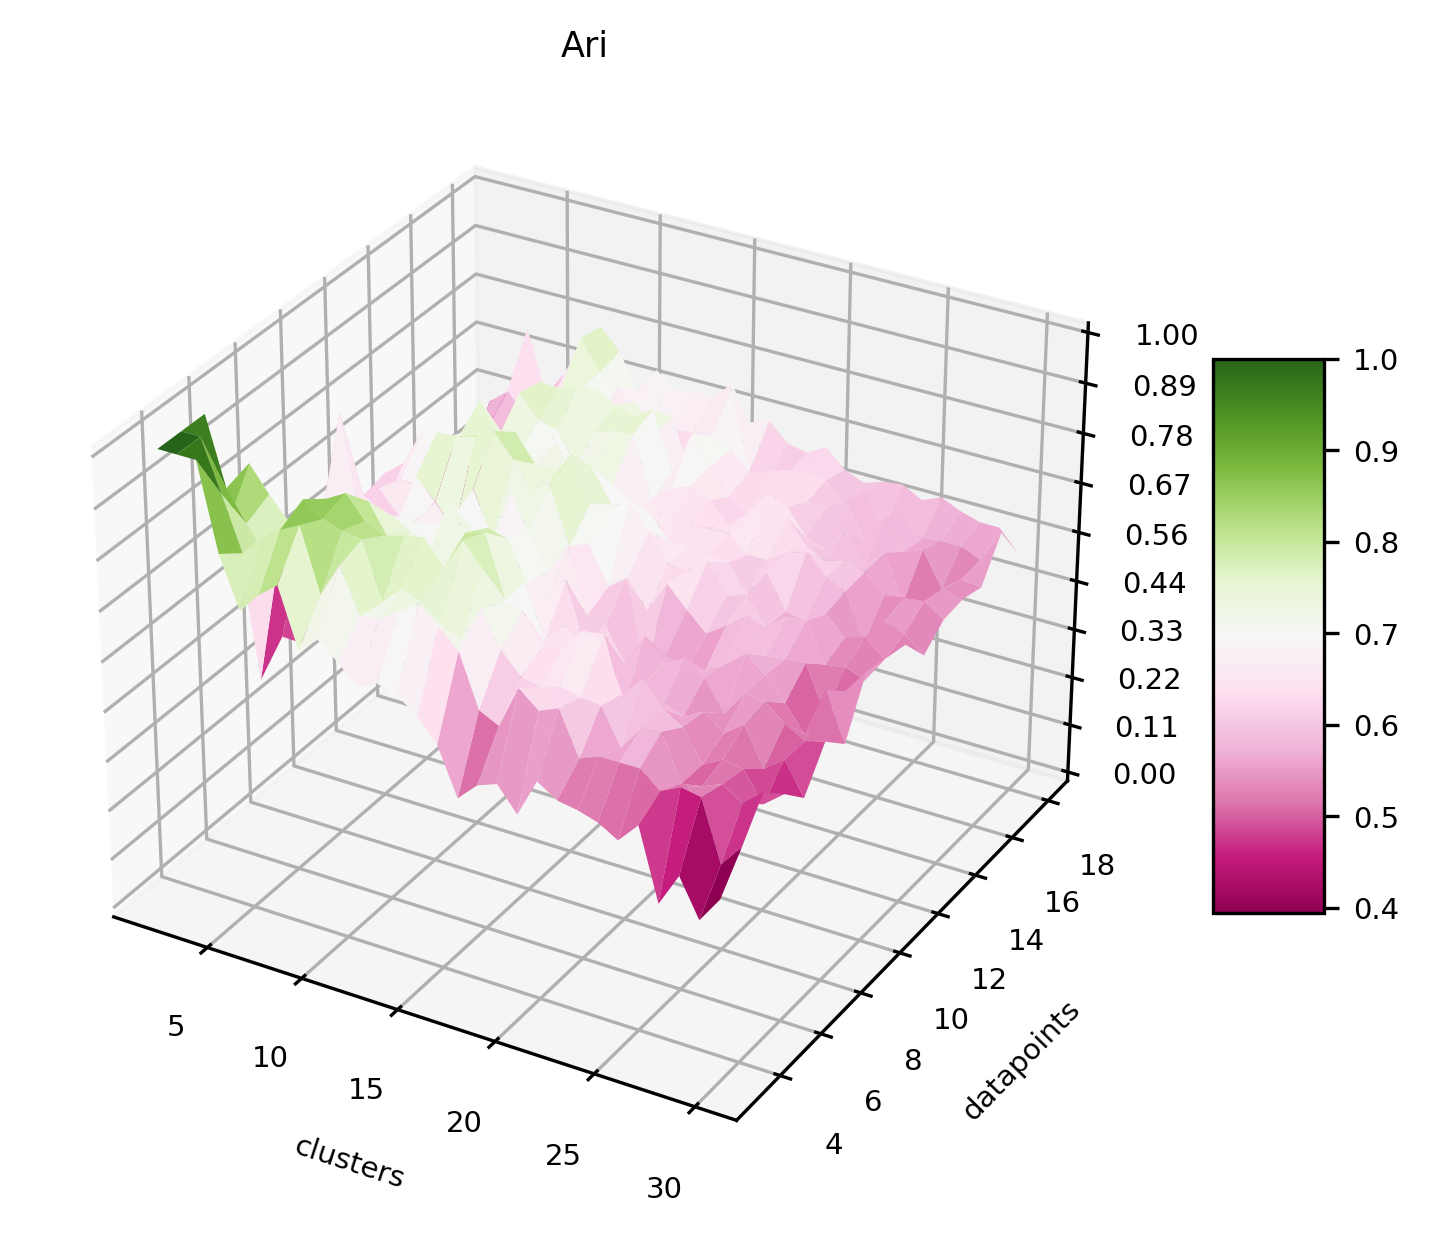

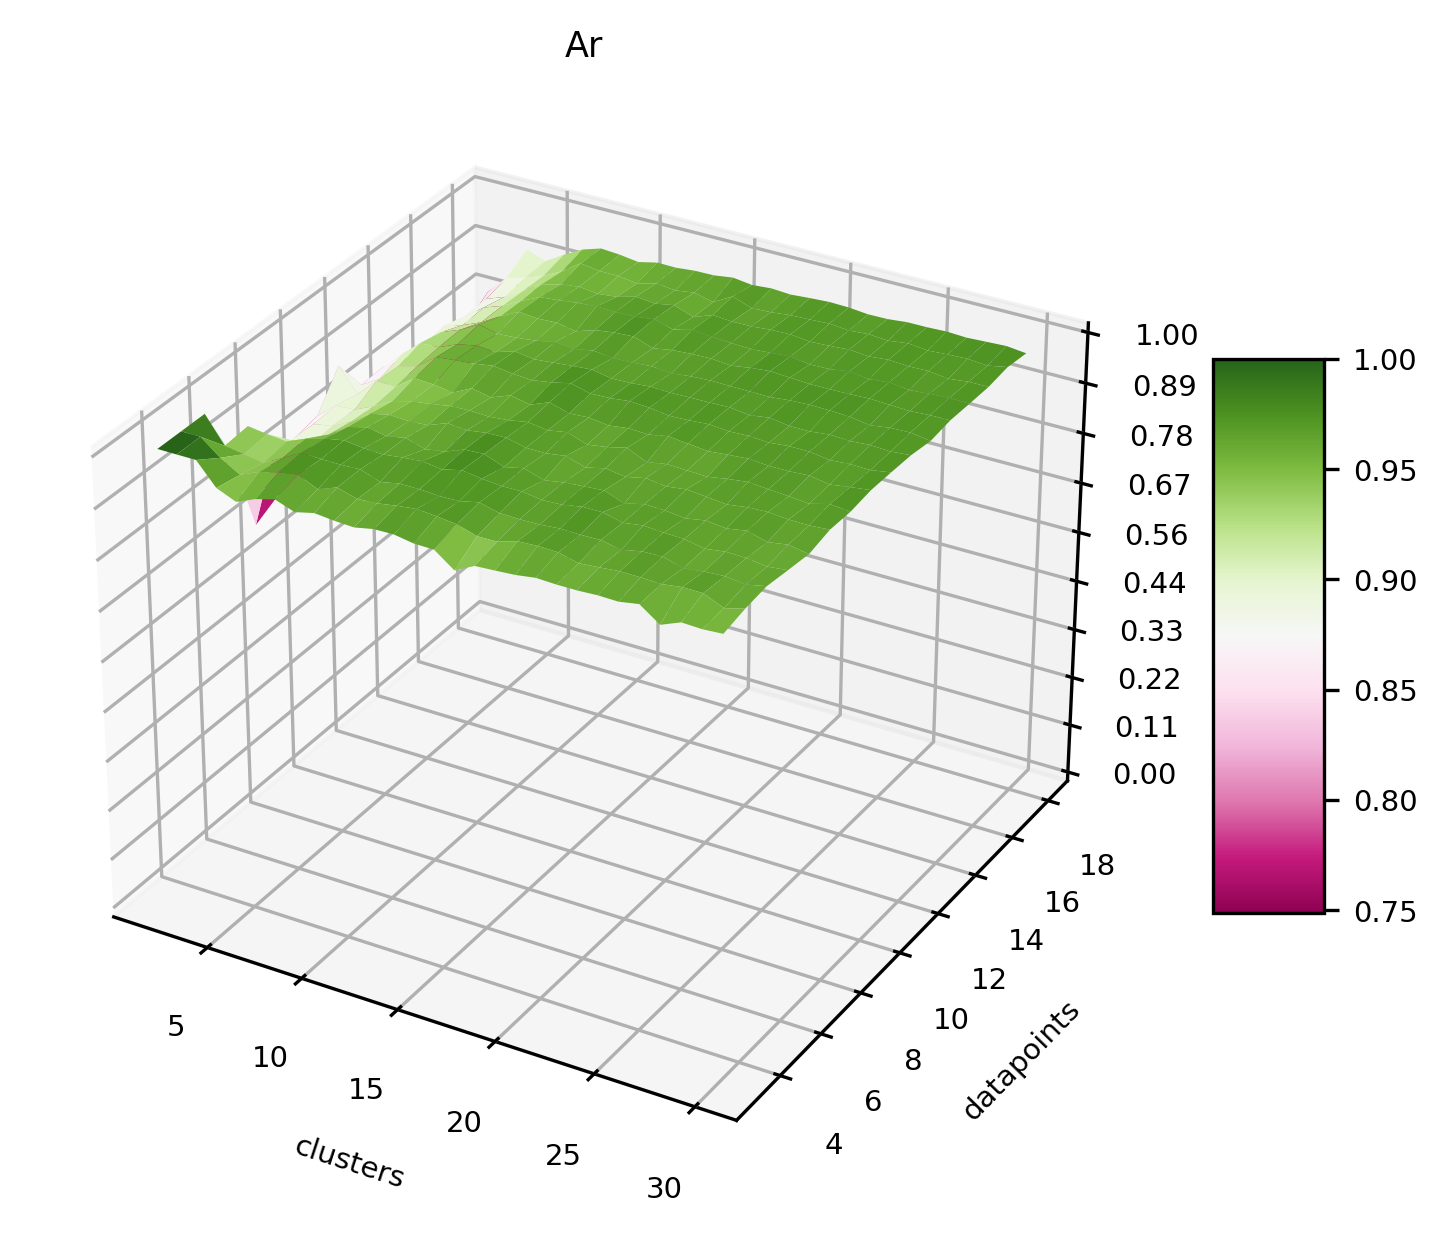

In [12]:
# axis
X = np.arange(clusters_min_static, clusters_max_static + 1, 1)
# X = X[::-1]
Y = np.arange(values_min_static, values_max_static + 1, 1)
# Y = Y[::-1]
X, Y = np.meshgrid(X, Y)
# print(X)
# print(Y)

# Ari
Z = np.array(fitness_static_ari).transpose()
# Z = Z[::-1]
# print(Z)
# set font
plt.rcParams.update({"font.size": 7})
plot_3d(X, Y, Z, "Ari")

# Ar
Z = np.array(fitness_static_ri).transpose()
plot_3d(X, Y, Z, "Ar")

# 2D plot of specific data point

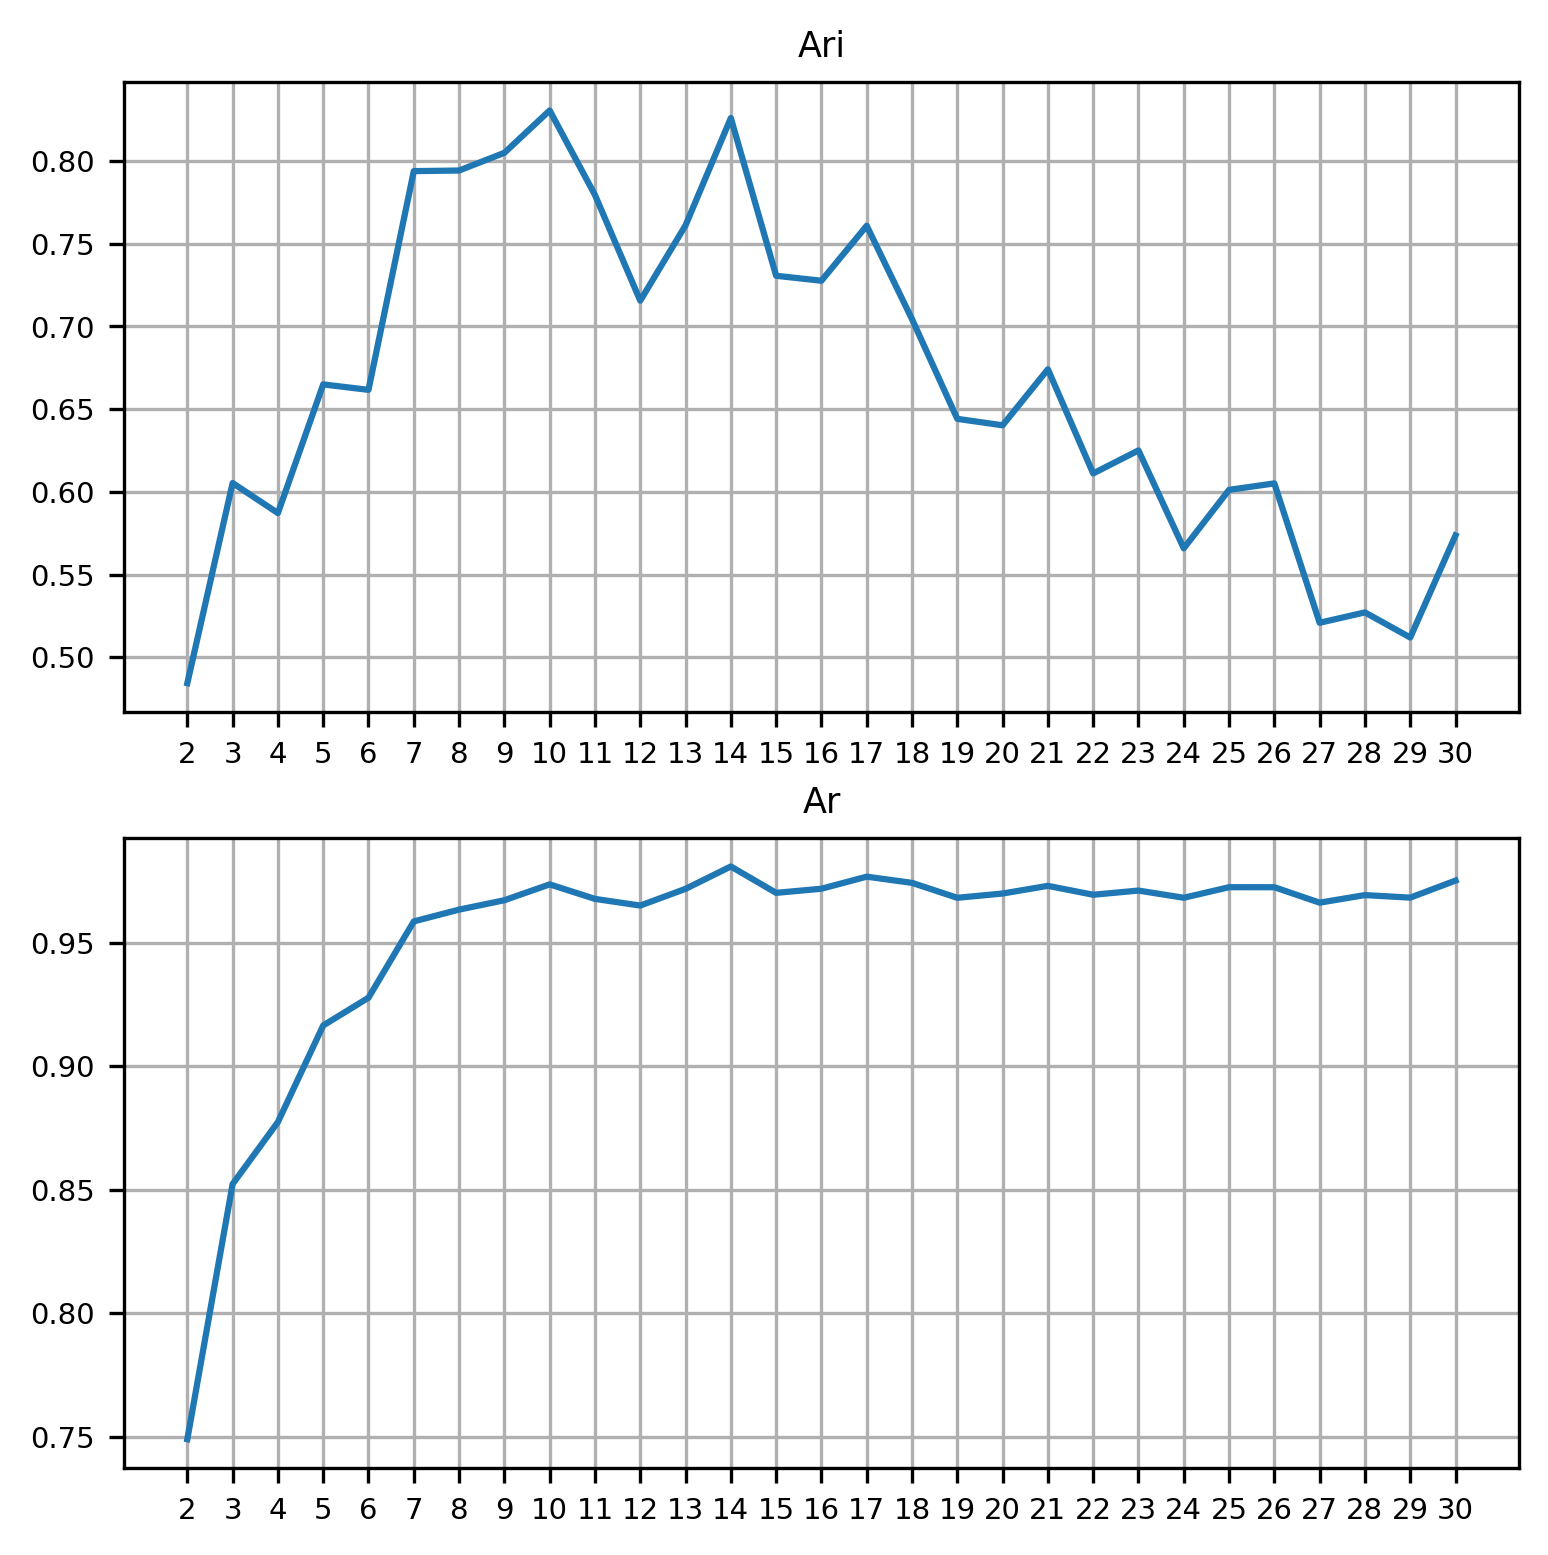

In [13]:
# ari
data_point = int(len(fitness_static_ari[0]) / 2)
test_data_fixed_points_ari = []
for i in range(0, (clusters_max_static - clusters_min_static) + 1):
    test_data_fixed_points_ari.append(fitness_static_ari[i][data_point])


data_point = int(len(fitness_static_ri[0]) / 2)
test_data_fixed_points_ar = []
for i in range(0, (clusters_max_static - clusters_min_static) + 1):
    test_data_fixed_points_ar.append(fitness_static_ri[i][data_point])

X = np.arange(clusters_min_static, clusters_max_static + 1, 1)


plt.figure(figsize=(6, 6), dpi=300)
plt.subplot(211)
plt.title("Ari")
plt.plot(X, test_data_fixed_points_ari)
plt.grid()
plt.xticks(X)

plt.subplot(212)
plt.title("Ar")
plt.plot(X, test_data_fixed_points_ar)
plt.grid()
plt.xticks(X)

plt.show()

# Dynamic items


[]

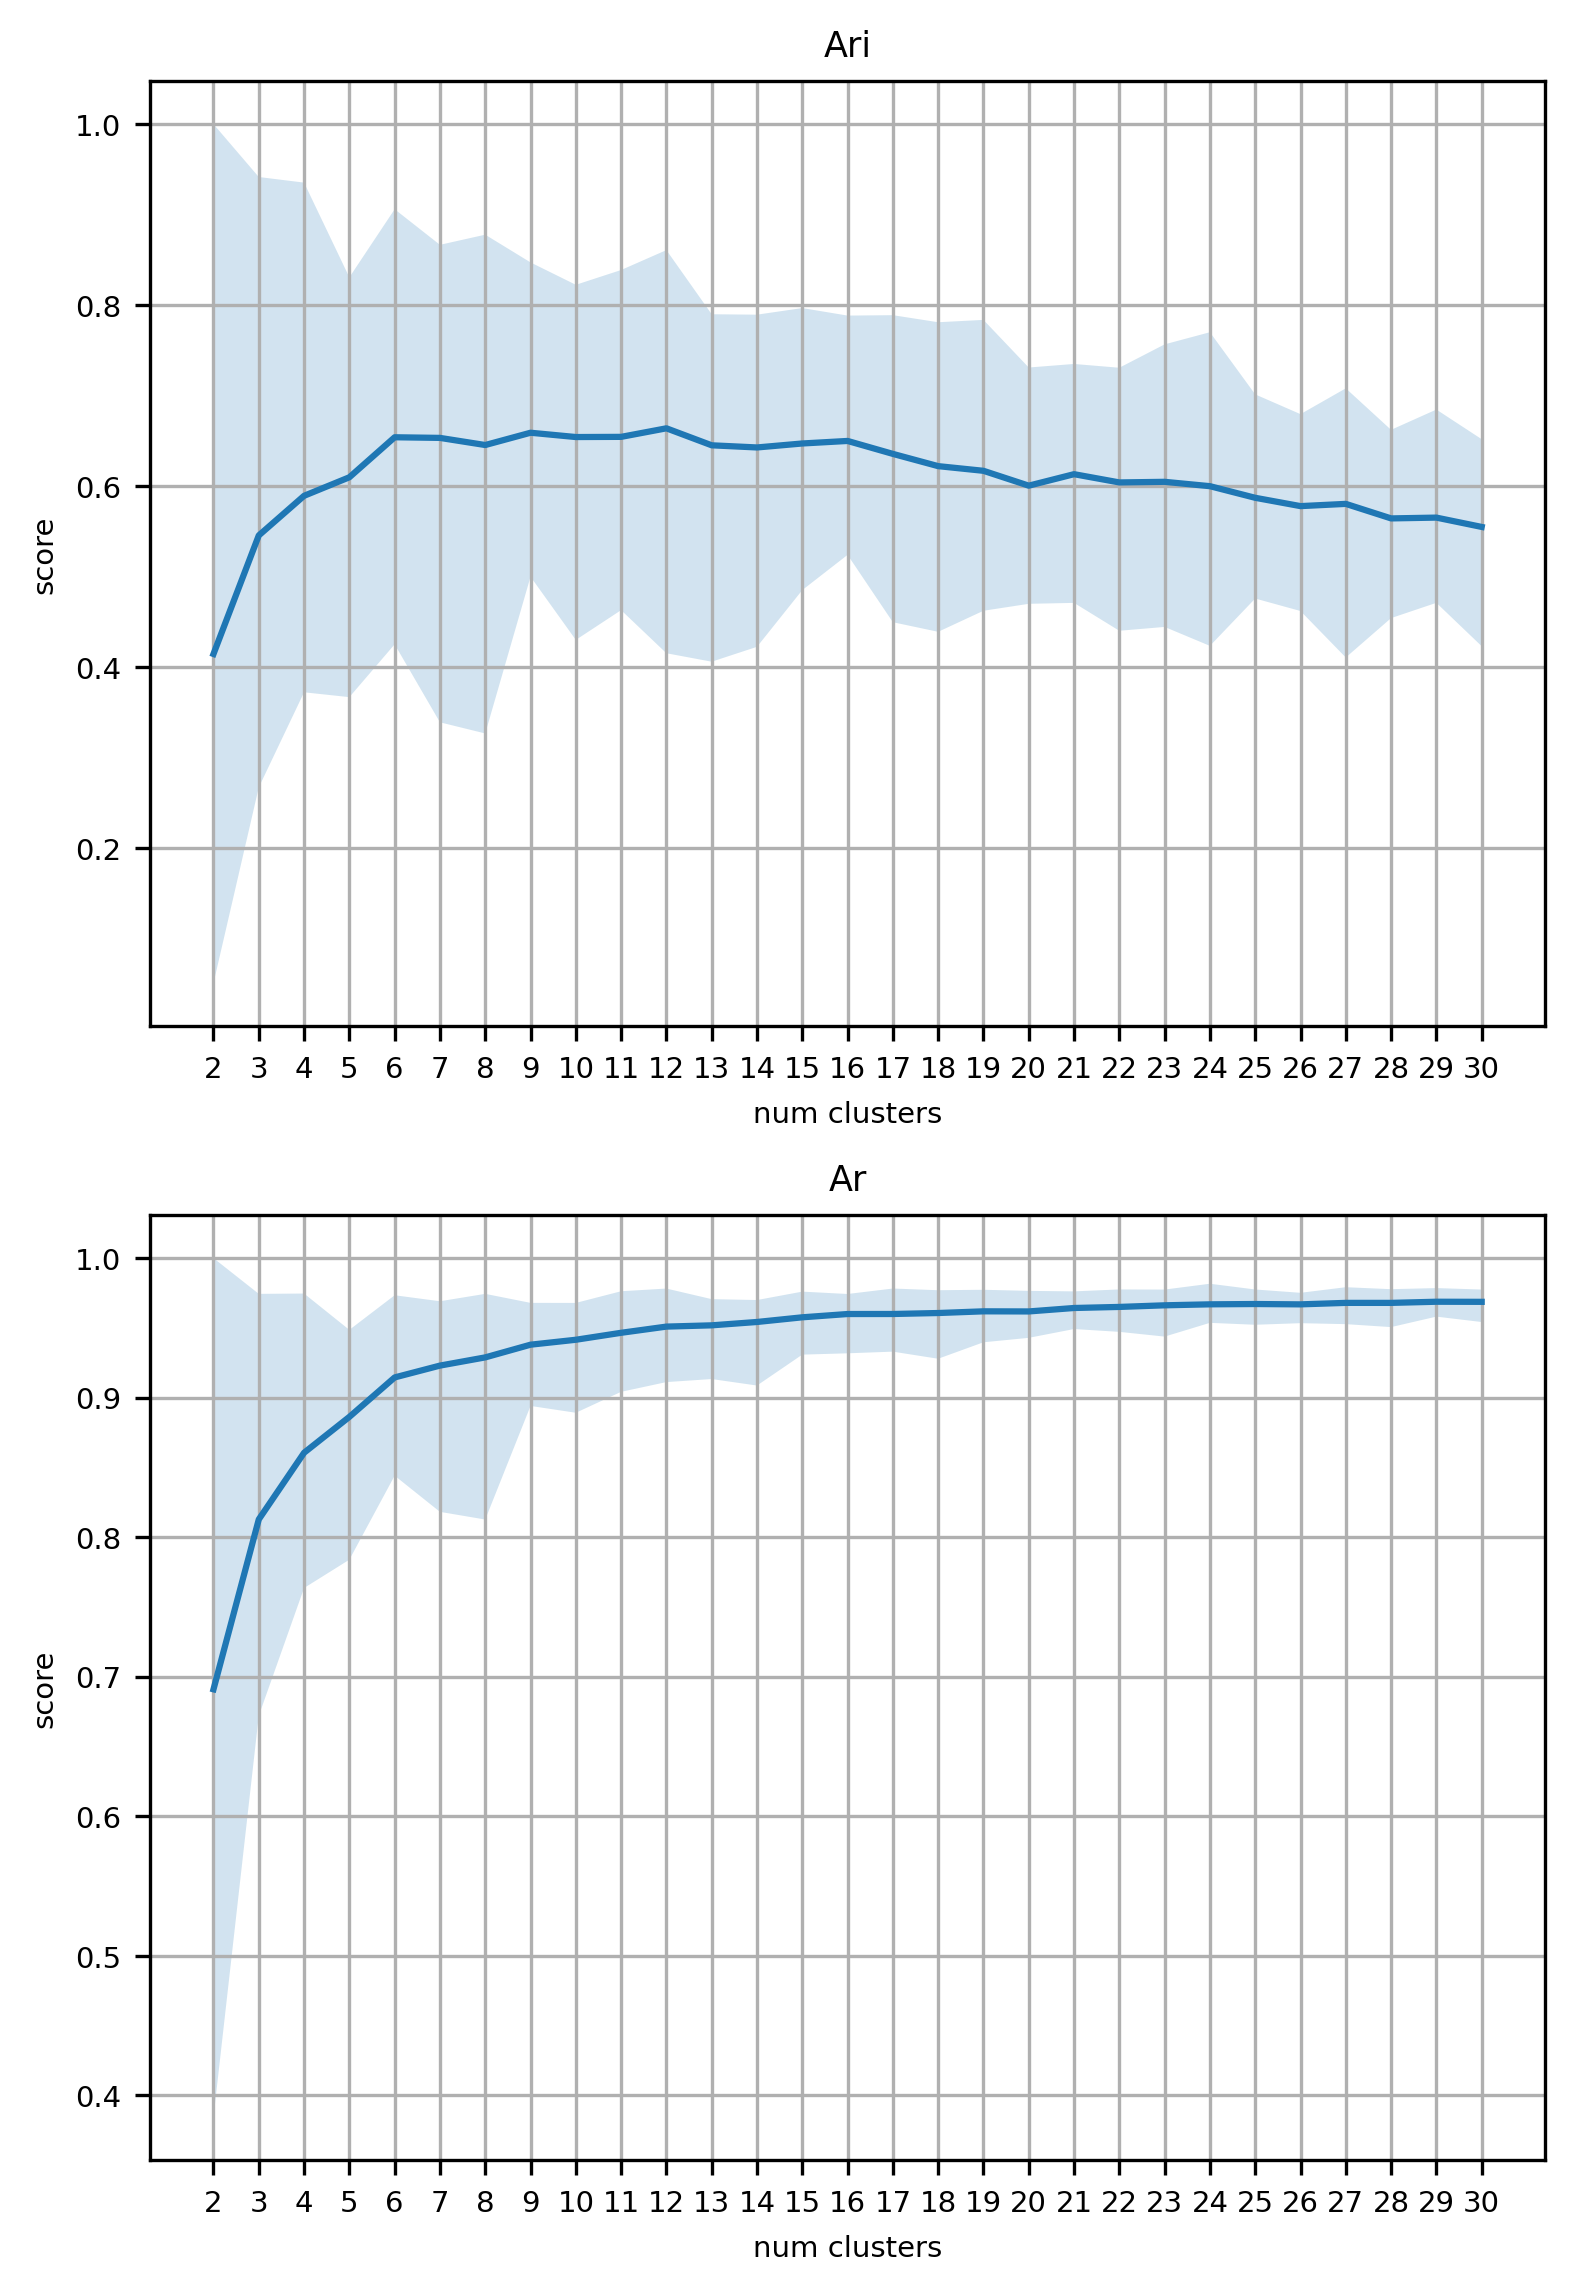

In [14]:
# calc mean and std
mean_ari = []
min_ari = []
max_ari = []
mean_ar = []
min_ar = []
max_ar = []

for i_ari, i_ar in zip(fitness_dynamic_ari, fitness_dynamic_ri):
    # ari
    mean_ari.append(np.mean(i_ari))
    min_ari.append(np.min(i_ari))
    max_ari.append(np.max(i_ari))

    # ar
    mean_ar.append(np.mean(i_ar))
    min_ar.append(np.min(i_ar))
    max_ar.append(np.max(i_ar))
# as np
mean_ari = np.array(mean_ari)
min_ari = np.array(min_ari)
max_ari = np.array(max_ari)
mean_ar = np.array(mean_ar)
min_ar = np.array(min_ar)
max_ar = np.array(max_ar)


# make plot
X = np.arange(clusters_min_dynamic, clusters_max_dynamic + 1, 1)


plt.figure(figsize=(6, 9), dpi=300)
plt.subplot(211)
plt.title("Ari")
plt.xlabel("num clusters")
plt.ylabel("score")
plt.plot(X, mean_ari)
plt.fill_between(X, min_ari, max_ari, alpha=0.2)
plt.grid()
plt.xticks(X)

plt.subplot(212)
plt.title("Ar")
plt.xlabel("num clusters")
plt.ylabel("score")
plt.plot(X, mean_ar)
plt.fill_between(X, min_ar, max_ar, alpha=0.2)
plt.grid()
plt.xticks(X)

plt.plot()